In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_outlier_stat(stats, stat_key='ratio', ax=None, title=None):
    """
    Plot outlier ratio of every channel
    """
    outlier_stat = stats[stat_key].numpy()
    channels = np.arange(len(outlier_stat))

    # check nan or inf in outlier_stat
    # print(f"average {stat_key}: {outlier_stat.mean()}")
    # print(f"nan: {np.isnan(outlier_stat).any()}")
    # print(f"inf: {np.isinf(outlier_stat).any()}")

    if 'l2_norm' in stat_key:
        outlier_stat = np.log10(outlier_stat)
        # set -inf to inf
        outlier_stat[np.isinf(outlier_stat)] = np.inf
        outlier_stat -= outlier_stat.min()
        # set inf to 0
        outlier_stat[np.isinf(outlier_stat)] = 0

    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(channels, outlier_stat, 'o', label=f'outlier_{stat_key}', markersize=1, color='red')

    # plot lines
    line_colors = ['blue', 'magenta', 'brown', 'black']
    for i in range(len(channels)):
        ax.plot([channels[i], channels[i]], [0, outlier_stat[i]], '-', linewidth=0.5, alpha=0.2, color=line_colors[i % len(line_colors)])

    # ax.bar(channels, outlier_stat, label=f'outlier_{stat_key}', color='red', alpha=0.5, width=1)

    ax.set_title(title)
    ax.legend()

def plot_outlier_all_stats(layer_stats, module_name=None):
    """
    Plot stat in a subgraph
    """
    num_subplots = 3
    fig, axs = plt.subplots(1, num_subplots, figsize=(5*num_subplots, 5))
    fig.suptitle(module_name)

    for i, (category, stats) in enumerate(layer_stats.items()):
        if 'norm' in module_name:
            if category == 'input':
                continue
        else:
            if category != 'input':
                continue

        title = f"{category} channel outlier ratio"
        plot_outlier_stat(stats, stat_key='outlier_ratio', ax=axs[0], title=title)
        title = f"{category} channel outlier l2 norm"
        plot_outlier_stat(stats, stat_key='outlier_l1_norm', ax=axs[1], title=title)
        title = f"{category} channel outlier all l2 norm"
        plot_outlier_stat(stats, stat_key='all_l2_norm', ax=axs[2], title=title)

    plt.show()

def print_mse(outlier_stats, layer_type_list):
    mse_dict = {}

    for module_name, layer_stats in outlier_stats.items():
        is_target_layer = False
        for layer_type in layer_type_list:
            if layer_type in module_name:
                is_target_layer = True
                break
        if not is_target_layer:
            continue

        for category, stats in layer_stats.items():
            if 'norm' in module_name:
                if category != 'output': continue
            elif 'matmul' not in module_name:
                # linear
                if category != 'input': continue

            for mse_name, mse_val in stats.items():
                if 'mse' not in mse_name:
                    continue
                if mse_name not in mse_dict:
                    mse_dict[mse_name] = []
                mse_dict[mse_name].append(mse_val)

    for mse_name, mse_vals in mse_dict.items():
        print(f"{mse_name} (avg): {np.mean(mse_vals)}")
        # print(f"{mse_name} (max): {np.max(mse_vals)}") # similar to mean
        

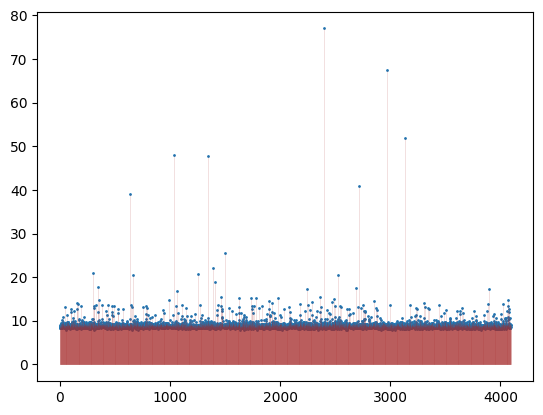

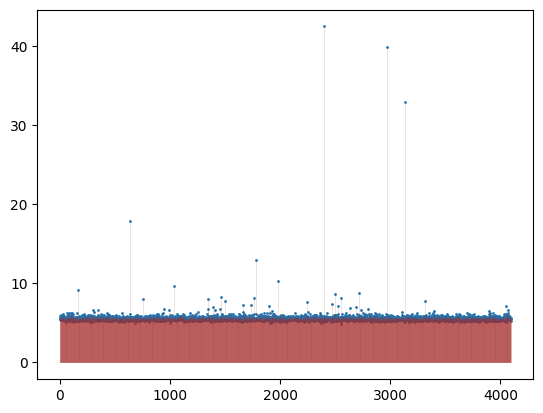

In [24]:
outlier_stats = torch.load('act_stats/opt-6.7b.pt')
outlier_stats = {k: v for k, v in outlier_stats.items() if 'norm' in k}

output_scales = []

for module_name, layer_stats in outlier_stats.items():
    output_stats = layer_stats['output']
    output_scale = output_stats['max'] - output_stats['min']
    output_scales.append(output_scale)


def quick_plot_vector(vector, title=None):
    fig, ax = plt.subplots()
    channels = np.arange(len(vector))
    ax.plot(channels, vector, 'o', markersize=1)

    for i in range(len(channels)):
        ax.plot([channels[i], channels[i]], [0, vector[i]], '-', linewidth=0.5, alpha=0.2, color='brown')

    ax.set_title(title)
    plt.show()

quick_plot_vector(torch.stack(output_scales, dim=0).max(dim=0)[0])
quick_plot_vector(torch.stack(output_scales, dim=0).mean(dim=0))

In [84]:
outlier_stats = torch.load('outlier_stats/3_sigma/opt-6.7b_outlier.pt')

for module_name, layer_stats in outlier_stats.items():
    if int(module_name.split('.')[3]) > 0:
        break
    print(module_name)

model.decoder.layers.0.self_attn_layer_norm
model.decoder.layers.0.self_attn.q_proj
model.decoder.layers.0.self_attn.k_proj
model.decoder.layers.0.self_attn.v_proj
model.decoder.layers.0.self_attn.qkt_matmul
model.decoder.layers.0.self_attn.pv_matmul
model.decoder.layers.0.self_attn.out_proj
model.decoder.layers.0.final_layer_norm
model.decoder.layers.0.fc1
model.decoder.layers.0.fc2


In [85]:
outlier_stats = torch.load('outlier_stats/3_sigma/llama-7b-meta_outlier.pt')

for module_name, layer_stats in outlier_stats.items():
    if int(module_name.split('.')[2]) > 0:
        break
    print(module_name)

model.layers.0.input_layernorm
model.layers.0.self_attn.q_proj
model.layers.0.self_attn.k_proj
model.layers.0.self_attn.v_proj
model.layers.0.self_attn.qkt_matmul
model.layers.0.self_attn.pv_matmul
model.layers.0.self_attn.o_proj
model.layers.0.post_attention_layernorm
model.layers.0.mlp.gate_proj
model.layers.0.mlp.up_proj
model.layers.0.mlp.down_proj


In [86]:
for module_name, layer_stats in outlier_stats.items():
    target_category = 'input' if 'norm' not in module_name else 'output'

    for category, stats in layer_stats.items():
        if category != target_category:
            continue
        for k, v in stats.items():
            print(k)
            # print(v)
    break

tensor_mean
tensor_std
tensor_min
tensor_max
channel_mean
channel_std
channel_min
channel_max
outlier_ratio
outlier_min
outlier_max
outlier_l1_norm
outlier_l2_norm
all_l2_norm


In [102]:
outlier_stats = torch.load('outlier_stats/3_sigma/llama-7b-meta_outlier.pt')

pct50_by_std = []
pct75_by_std = []

for module_name, layer_stats in outlier_stats.items():
    if 'down_proj' not in module_name:
        continue
    stats = layer_stats['input']
    mean_outlier_ratio = torch.mean(stats['outlier_ratio'])
    mean_outlier_l1_norm = torch.mean(stats['outlier_l1_norm'])
    tensor_std = stats['tensor_std']
    tensor_max = stats['tensor_max']

    # get 25% quantile of channel max
    channel_max = stats['channel_max']
    percentiles = []
    for i in range(1, 8):
        percentiles.append(np.percentile(channel_max, 100-100/(2 ** i)))

    print(f"{module_name}: {tensor_std:.4f}, {tensor_max}")
    print([f"{i:.4f}" for i in percentiles])
    print()

    pct50_by_std.append(percentiles[0] / tensor_std)
    pct75_by_std.append(percentiles[1] / tensor_std)

    _, reorder_index = torch.sort(channel_max)
    channel_std = stats['channel_std']
    reorder_channel_std = torch.index_select(channel_std, -1, reorder_index)
    grouped_mean_reordered_channel_std = torch.mean(reorder_channel_std.view(-1, 128), dim=1)
    print(grouped_mean_reordered_channel_std)

print(pct50_by_std)
print(pct75_by_std)

print(np.mean(pct50_by_std))
print(np.mean(pct75_by_std))

model.layers.0.mlp.down_proj: 0.0071, 4.75
['0.2080', '0.3819', '0.5626', '0.7652', '0.9507', '1.1455', '1.3779']

tensor([0.0079, 0.0064, 0.0065, 0.0056, 0.0067, 0.0053, 0.0051, 0.0047, 0.0049,
        0.0053, 0.0050, 0.0047, 0.0053, 0.0052, 0.0046, 0.0052, 0.0049, 0.0051,
        0.0050, 0.0054, 0.0046, 0.0051, 0.0045, 0.0046, 0.0048, 0.0051, 0.0045,
        0.0045, 0.0048, 0.0047, 0.0045, 0.0050, 0.0045, 0.0043, 0.0047, 0.0046,
        0.0047, 0.0048, 0.0044, 0.0047, 0.0043, 0.0047, 0.0044, 0.0047, 0.0047,
        0.0049, 0.0046, 0.0046, 0.0045, 0.0046, 0.0045, 0.0045, 0.0048, 0.0044,
        0.0046, 0.0045, 0.0048, 0.0048, 0.0049, 0.0046, 0.0045, 0.0047, 0.0048,
        0.0047, 0.0047, 0.0047, 0.0050, 0.0047, 0.0056, 0.0046, 0.0049, 0.0055,
        0.0048, 0.0047, 0.0052, 0.0052, 0.0050, 0.0054, 0.0052, 0.0057, 0.0067,
        0.0065, 0.0067, 0.0064, 0.0081, 0.0094])
model.layers.1.mlp.down_proj: 0.0134, 5.91015625
['0.3660', '0.5947', '0.8740', '1.1826', '1.4737', '1.7266', '1.969

In [62]:
outlier_stats = torch.load('outlier_stats/3_sigma/opt-13b_outlier.pt')
layer_type_list = ['norm', 'out_proj', 'fc2']
print_mse(outlier_stats, layer_type_list)

normal_mse_int4 (avg): 0.007424484007060528
normal_mse_int8 (avg): 2.3732054614811204e-05
outlier_mse_int4 (avg): 5.495406627655029
outlier_mse_int8 (avg): 0.012461481615900993
outlier_mse_e1m2 (avg): 17.106182098388672
outlier_mse_e2m1 (avg): 6.464980125427246


In [63]:
outlier_stats = torch.load('outlier_stats/3_sigma/opt-30b_outlier.pt')
layer_type_list = ['norm', 'out_proj', 'fc2']
print_mse(outlier_stats, layer_type_list)

normal_mse_int4 (avg): 0.007813011296093464
normal_mse_int8 (avg): 2.3768327082507312e-05
outlier_mse_int4 (avg): 7.12378454208374
outlier_mse_int8 (avg): 0.016923250630497932
outlier_mse_e1m2 (avg): 16.721511840820312
outlier_mse_e2m1 (avg): 7.654246807098389


In [64]:
outlier_stats = torch.load('outlier_stats/3_sigma/opt-66b_outlier.pt')
layer_type_list = ['norm', 'out_proj', 'fc2']
print_mse(outlier_stats, layer_type_list)

normal_mse_int4 (avg): 0.007982876151800156
normal_mse_int8 (avg): 2.3678561774431728e-05
outlier_mse_int4 (avg): 8.52147102355957
outlier_mse_int8 (avg): 0.024287868291139603
outlier_mse_e1m2 (avg): 14.683540344238281
outlier_mse_e2m1 (avg): 9.072004318237305


In [65]:
outlier_stats = torch.load('outlier_stats/3_sigma/llama-13b-meta_outlier.pt')
layer_type_list = ['norm', 'out_proj', 'fc2']
print_mse(outlier_stats, layer_type_list)

normal_mse_int4 (avg): 0.0015405860031023622
normal_mse_int8 (avg): 4.68465168523835e-06
outlier_mse_int4 (avg): 0.504895031452179
outlier_mse_int8 (avg): 0.0010609651217237115
outlier_mse_e1m2 (avg): 1.874769926071167
outlier_mse_e2m1 (avg): 0.34859293699264526


In [66]:
outlier_stats = torch.load('outlier_stats/3_sigma/llama-30b-meta_outlier.pt')
layer_type_list = ['norm', 'out_proj', 'fc2']
print_mse(outlier_stats, layer_type_list)

normal_mse_int4 (avg): 0.0014868236612528563
normal_mse_int8 (avg): 4.5220426727610175e-06
outlier_mse_int4 (avg): 0.546930193901062
outlier_mse_int8 (avg): 0.0012016859836876392
outlier_mse_e1m2 (avg): 1.8582772016525269
outlier_mse_e2m1 (avg): 0.37679755687713623


In [67]:
outlier_stats = torch.load('outlier_stats/3_sigma/llama-65b-meta_outlier.pt')
layer_type_list = ['norm', 'out_proj', 'fc2']
print_mse(outlier_stats, layer_type_list)

normal_mse_int4 (avg): 0.0013013985008001328
normal_mse_int8 (avg): 3.958006800530711e-06
outlier_mse_int4 (avg): 0.5455704927444458
outlier_mse_int8 (avg): 0.001078353961929679
outlier_mse_e1m2 (avg): 1.6605764627456665
outlier_mse_e2m1 (avg): 0.3962136209011078


In [56]:
outlier_stats = torch.load('outlier_stats/3_sigma/opt-6.7b_outlier.pt')
layer_type_list = ['norm', 'out_proj', 'fc2']
print_mse(outlier_stats, layer_type_list)

print()

outlier_stats = torch.load('outlier_stats/6_sigma/opt-6.7b_outlier.pt')
layer_type_list = ['norm', 'out_proj', 'fc2']
print_mse(outlier_stats, layer_type_list)


normal_mse_int4 (avg): 0.00765487365424633
normal_mse_int8 (avg): 2.4027911422308534e-05
outlier_mse_int4 (avg): 4.6257548332214355
outlier_mse_int8 (avg): 0.010868181474506855
outlier_mse_e1m2 (avg): 15.003458023071289
outlier_mse_e2m1 (avg): 6.039557456970215

normal_mse_int4 (avg): 0.026600921526551247
normal_mse_int8 (avg): 9.585767111275345e-05
outlier_mse_int4 (avg): 3.0608201026916504
outlier_mse_int8 (avg): 0.010497258976101875
outlier_mse_e1m2 (avg): 21.605985641479492
outlier_mse_e2m1 (avg): 5.681475639343262


In [57]:
outlier_stats = torch.load('outlier_stats/3_sigma/opt-6.7b_outlier.pt')
layer_type_list = ['matmul']
print_mse(outlier_stats, layer_type_list)

print()

outlier_stats = torch.load('outlier_stats/6_sigma/opt-6.7b_outlier.pt')
layer_type_list = ['matmul']
print_mse(outlier_stats, layer_type_list)


normal_mse_int4 (avg): 0.03803255409002304
normal_mse_int8 (avg): 0.00011548190377652645
outlier_mse_int4 (avg): 0.14325954020023346
outlier_mse_int8 (avg): 0.0004413838032633066
outlier_mse_e1m2 (avg): 0.20042110979557037
outlier_mse_e2m1 (avg): 0.31519392132759094

normal_mse_int4 (avg): 0.15121904015541077
normal_mse_int8 (avg): 0.00046066459617577493
outlier_mse_int4 (avg): 0.0785396471619606
outlier_mse_int8 (avg): 0.00021625736553687602
outlier_mse_e1m2 (avg): 0.07889077812433243
outlier_mse_e2m1 (avg): 0.2569892406463623


In [61]:
outlier_stats = torch.load('outlier_stats/3_sigma/llama-7b-meta_outlier.pt')
layer_type_list = ['norm', 'o_proj', 'down_proj']
print_mse(outlier_stats, layer_type_list)

print()

outlier_stats = torch.load('outlier_stats/6_sigma/llama-7b-meta_outlier.pt')
layer_type_list = ['norm', 'o_proj', 'down_proj']
print_mse(outlier_stats, layer_type_list)

normal_mse_int4 (avg): 0.0010314645478501916
normal_mse_int8 (avg): 3.2670609471097123e-06
outlier_mse_int4 (avg): 0.9095916152000427
outlier_mse_int8 (avg): 0.017372291535139084
outlier_mse_e1m2 (avg): 2.9058172702789307
outlier_mse_e2m1 (avg): 1.131797194480896

normal_mse_int4 (avg): 0.003961300943046808
normal_mse_int8 (avg): 1.3026813576288987e-05
outlier_mse_int4 (avg): 3.943507432937622
outlier_mse_int8 (avg): 0.053659986704587936
outlier_mse_e1m2 (avg): 13.461594581604004
outlier_mse_e2m1 (avg): 6.310998916625977


In [60]:
outlier_stats = torch.load('outlier_stats/3_sigma/llama-7b-meta_outlier.pt')
layer_type_list = ['matmul']
print_mse(outlier_stats, layer_type_list)

print()

outlier_stats = torch.load('outlier_stats/6_sigma/llama-7b-meta_outlier.pt')
layer_type_list = ['matmul']
print_mse(outlier_stats, layer_type_list)

normal_mse_int4 (avg): 0.019856257364153862
normal_mse_int8 (avg): 6.038996434654109e-05
outlier_mse_int4 (avg): 0.28473666310310364
outlier_mse_int8 (avg): 0.0009774630889296532
outlier_mse_e1m2 (avg): 0.7618732452392578
outlier_mse_e2m1 (avg): 0.28524157404899597

normal_mse_int4 (avg): 0.0779525563120842
normal_mse_int8 (avg): 0.00024095863045658916
outlier_mse_int4 (avg): 0.3196185529232025
outlier_mse_int8 (avg): 0.0009761085384525359
outlier_mse_e1m2 (avg): 0.2107054591178894
outlier_mse_e2m1 (avg): 0.5051059126853943


/home/xuechenhao/anaconda3/envs/omniquant/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


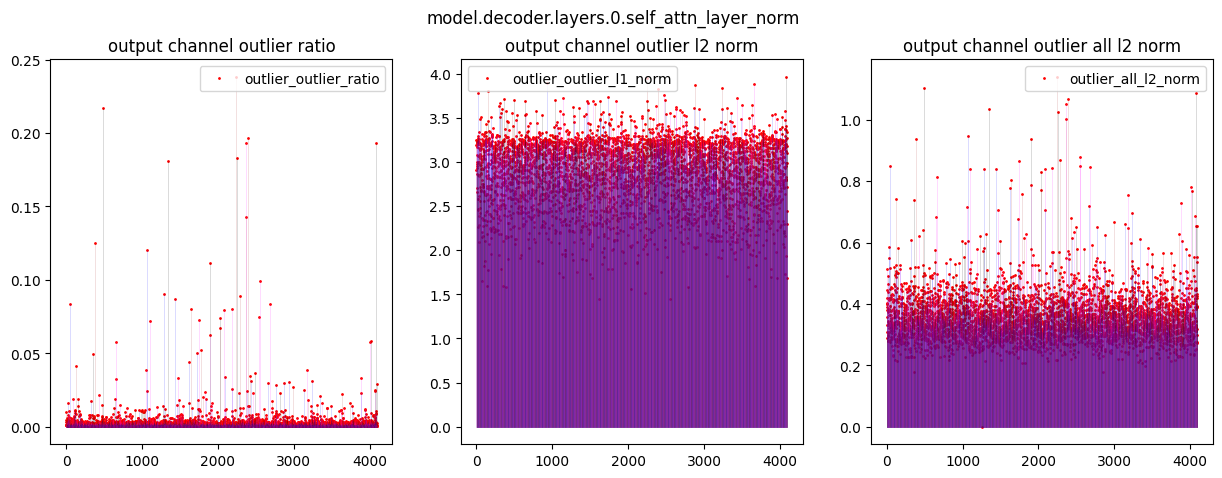

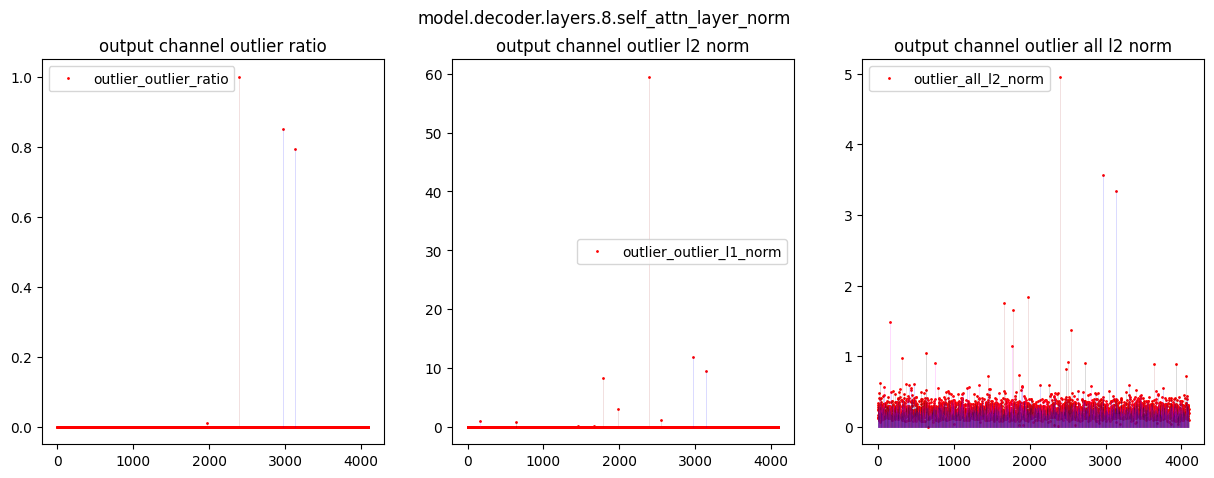

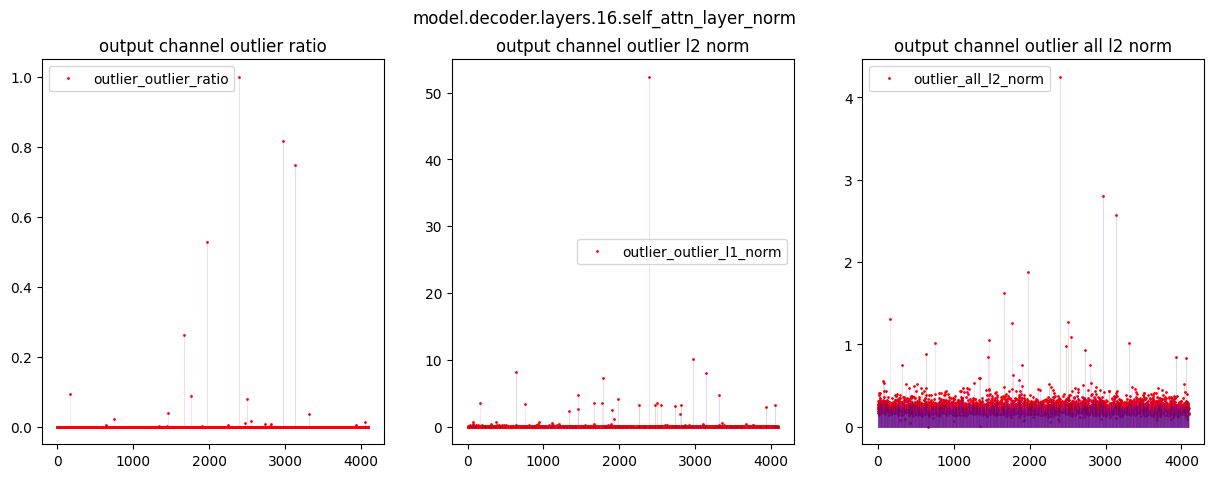

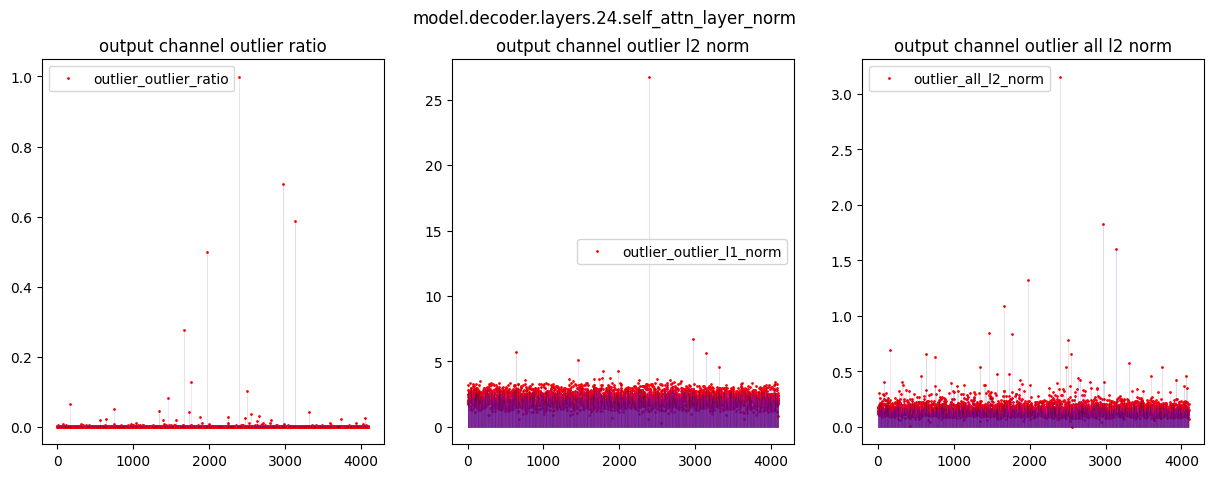

In [7]:
outlier_stats = torch.load('outlier_stats/3_sigma/opt-6.7b_outlier.pt')

for module_name, layer_stats in outlier_stats.items():
    # only examine layernorm
    if 'self_attn_layer_norm' not in module_name:
        continue
    # check every 4 layers
    if int(module_name.split('.')[3]) % 8 != 0:
        continue

    plot_outlier_all_stats(layer_stats, module_name=module_name)

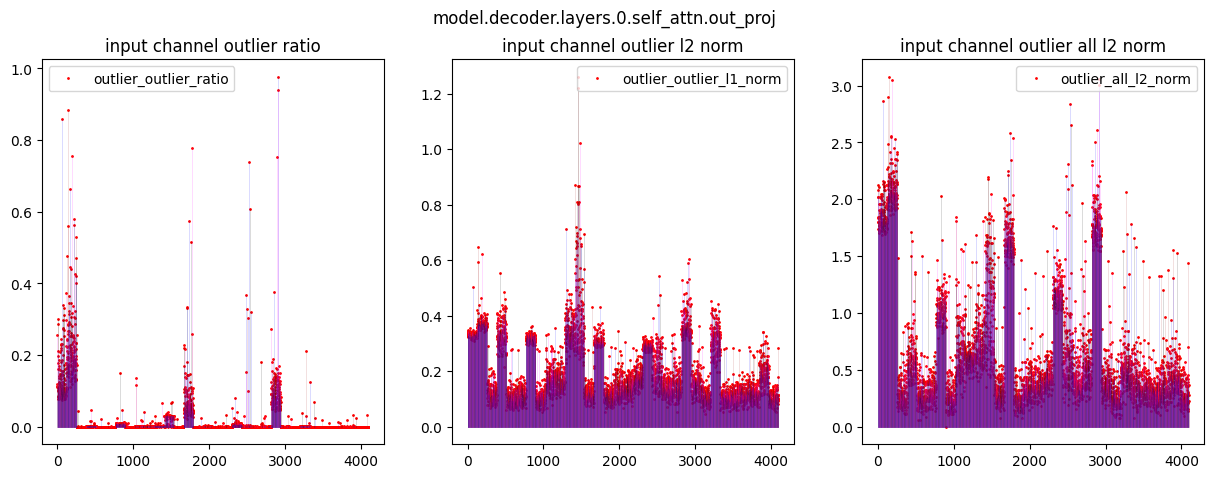

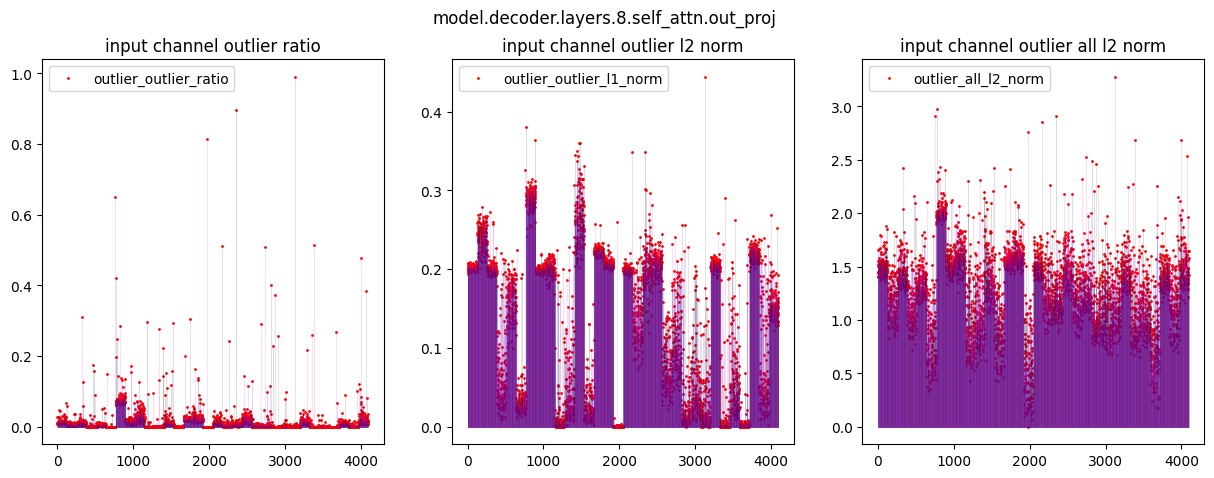

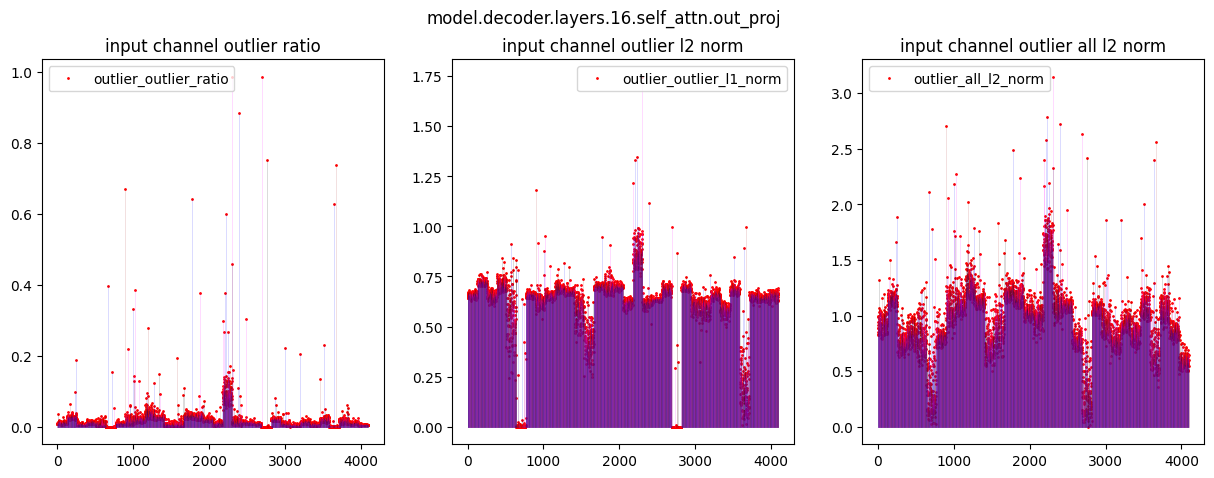

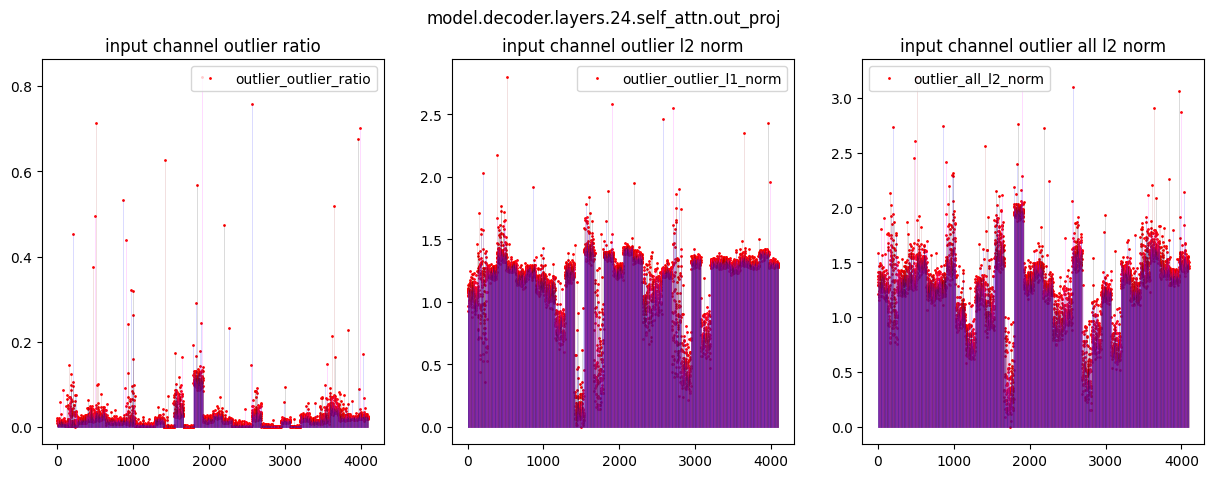

In [8]:
outlier_stats = torch.load('outlier_stats/3_sigma/opt-6.7b_outlier.pt')

for module_name, layer_stats in outlier_stats.items():
    # only examine layernorm
    if 'out_proj' not in module_name:
        continue
    # check every 4 layers
    if int(module_name.split('.')[3]) % 8 != 0:
        continue

    plot_outlier_all_stats(layer_stats, module_name=module_name)

/tmp/ipykernel_31318/3609139490.py:19: RuntimeWarning: divide by zero encountered in log10
  outlier_stat = np.log10(outlier_stat)


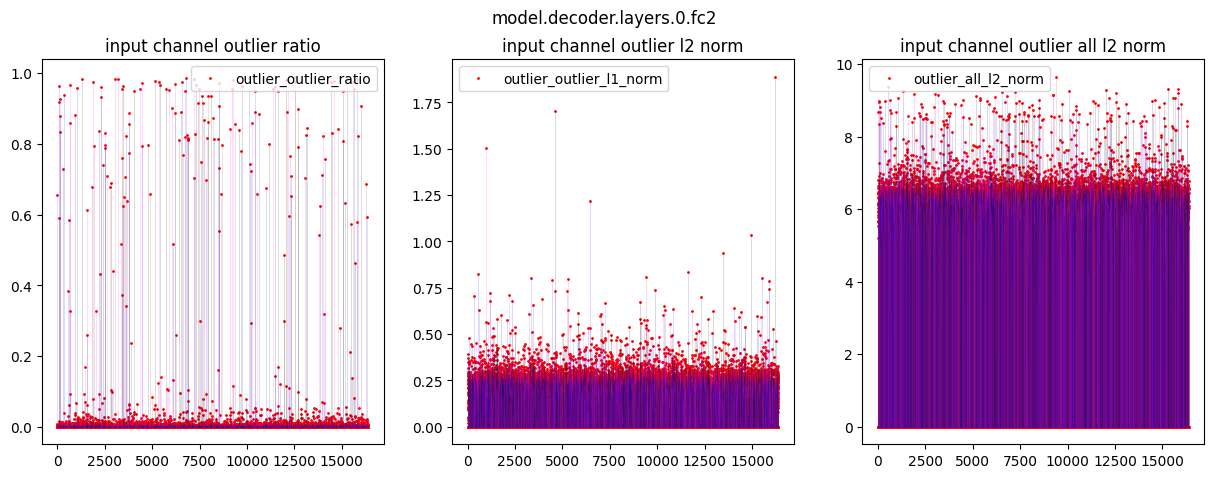

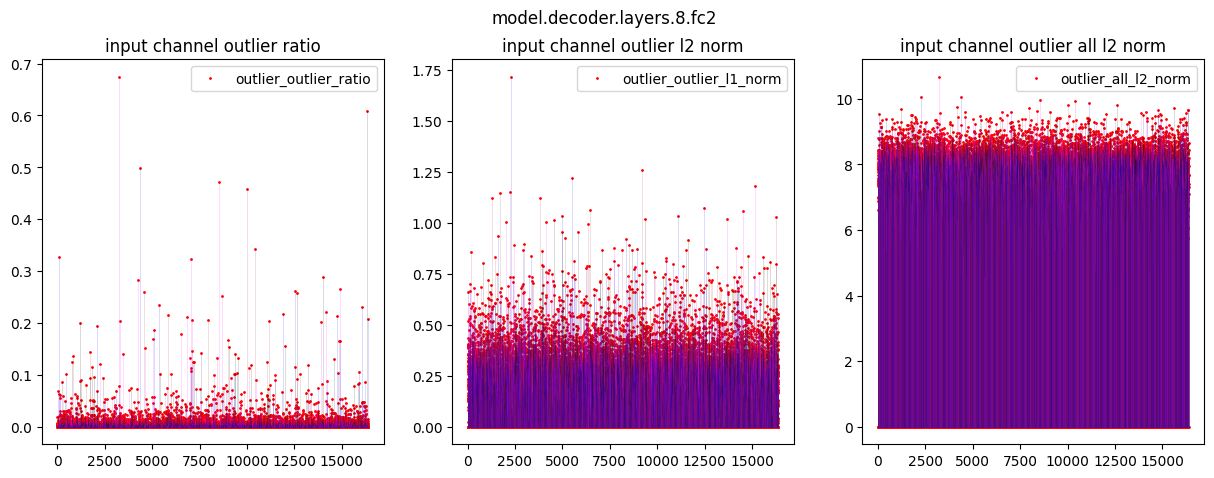

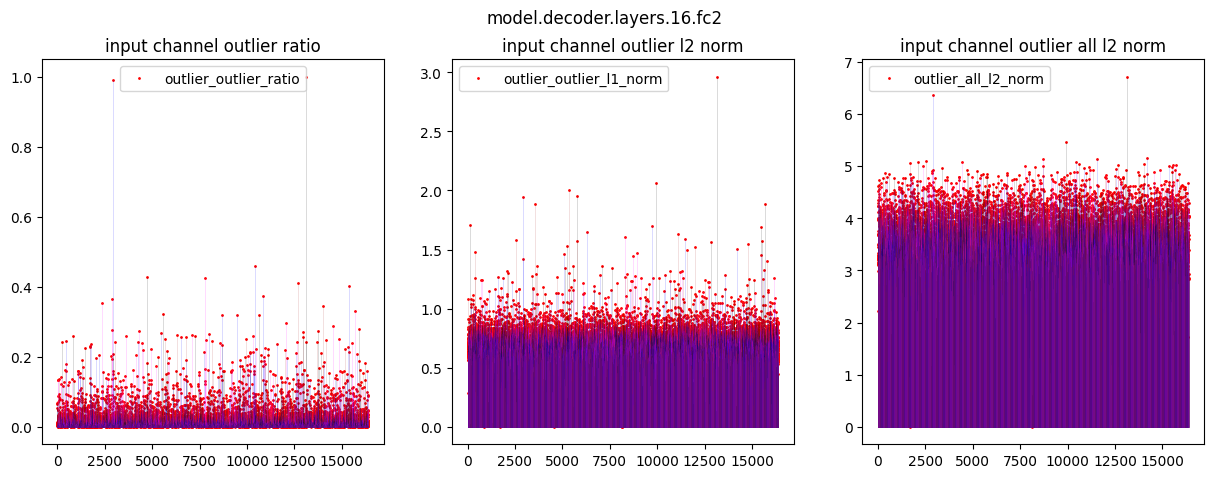

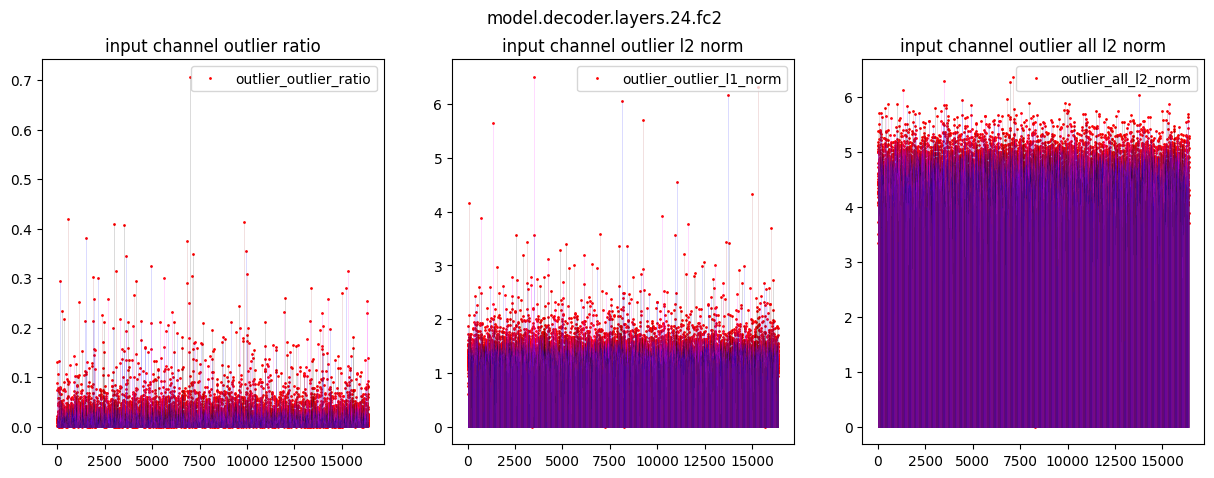

In [9]:
outlier_stats = torch.load('outlier_stats/3_sigma/opt-6.7b_outlier.pt')

for module_name, layer_stats in outlier_stats.items():
    # only examine layernorm
    if 'fc2' not in module_name:
        continue
    # check every 4 layers
    if int(module_name.split('.')[3]) % 8 != 0:
        continue

    plot_outlier_all_stats(layer_stats, module_name=module_name)

In [10]:
outlier_stats = torch.load('outlier_stats/3_sigma/llama-7b-meta_outlier.pt')

for module_name, layer_stats in outlier_stats.items():
    if int(module_name.split('.')[2]) % 8 > 0:
        break
    print(module_name)


model.layers.0.input_layernorm
model.layers.0.self_attn.q_proj
model.layers.0.self_attn.k_proj
model.layers.0.self_attn.v_proj
model.layers.0.self_attn.qkt_matmul
model.layers.0.self_attn.pv_matmul
model.layers.0.self_attn.o_proj
model.layers.0.post_attention_layernorm
model.layers.0.mlp.gate_proj
model.layers.0.mlp.up_proj
model.layers.0.mlp.down_proj


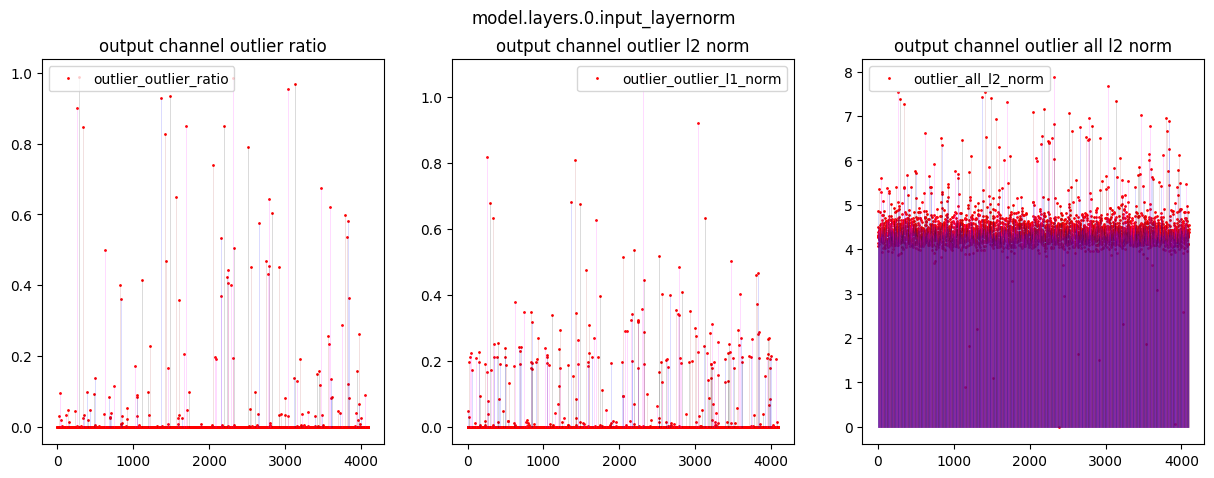

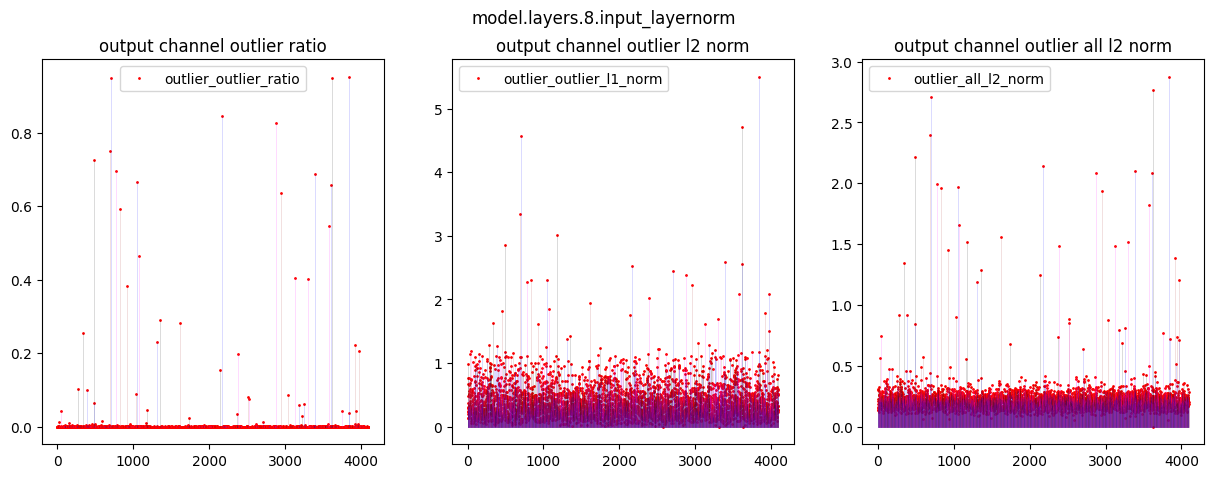

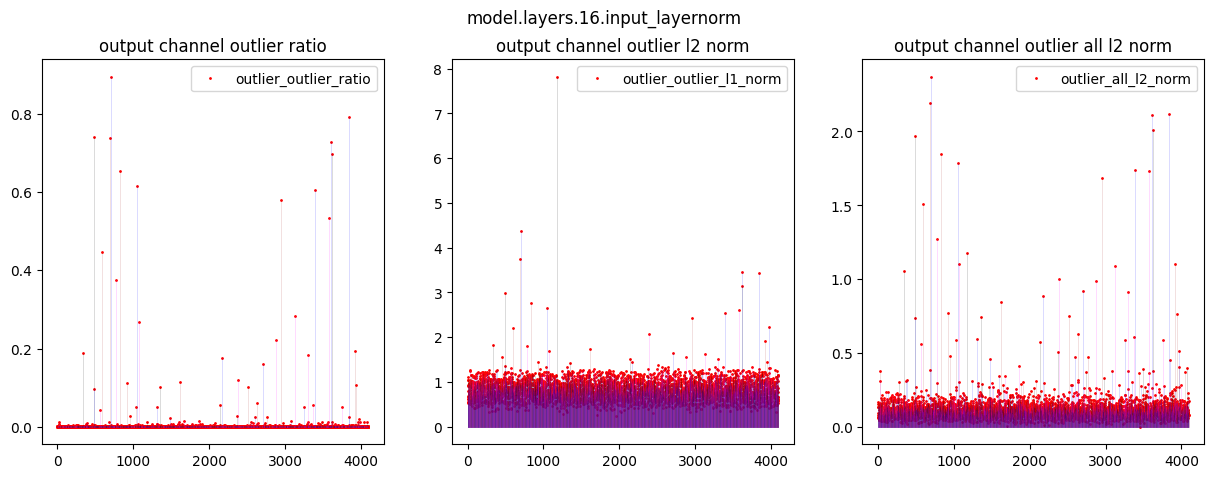

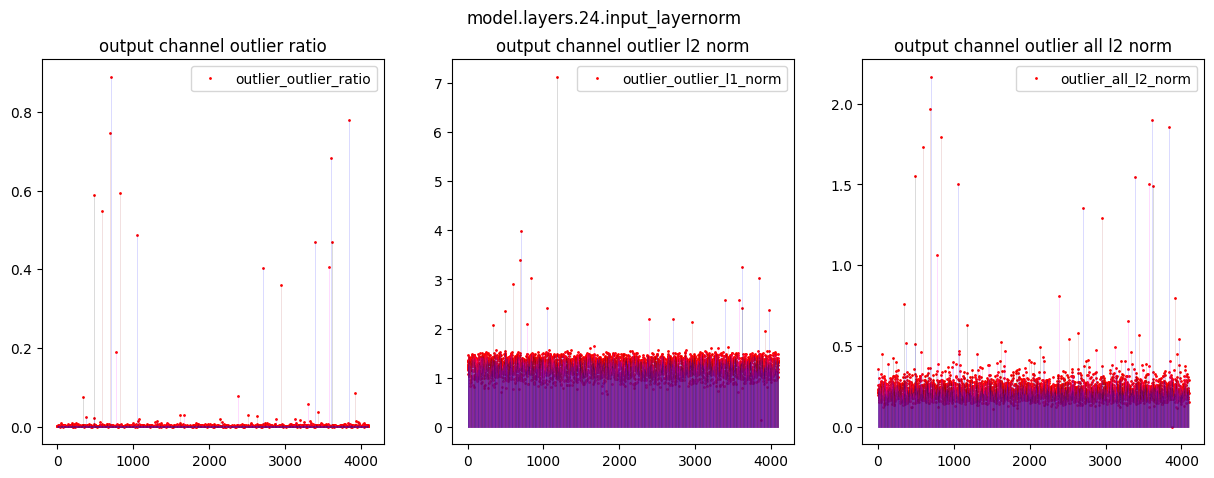

In [11]:
outlier_stats = torch.load('outlier_stats/3_sigma/llama-7b-meta_outlier.pt')

for module_name, layer_stats in outlier_stats.items():
    if 'input_layernorm' not in module_name:
        continue

    if int(module_name.split('.')[2]) % 8 != 0:
        continue

    plot_outlier_all_stats(layer_stats, module_name=module_name)


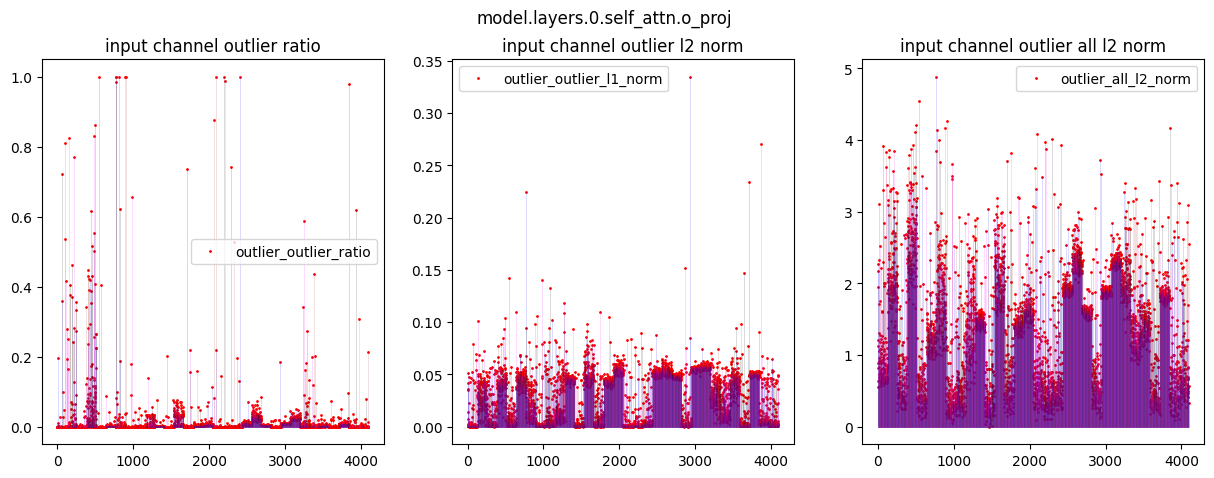

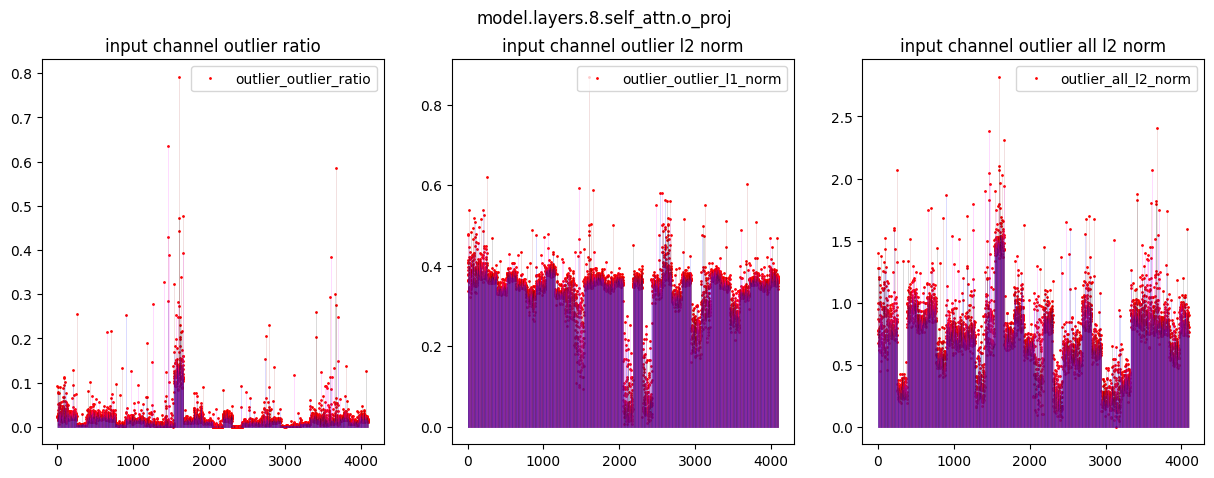

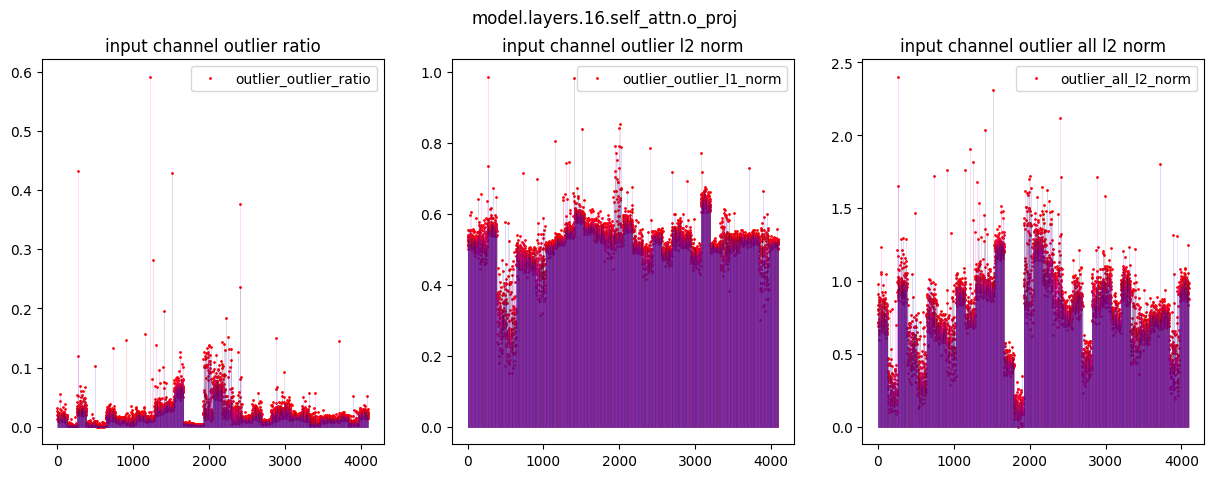

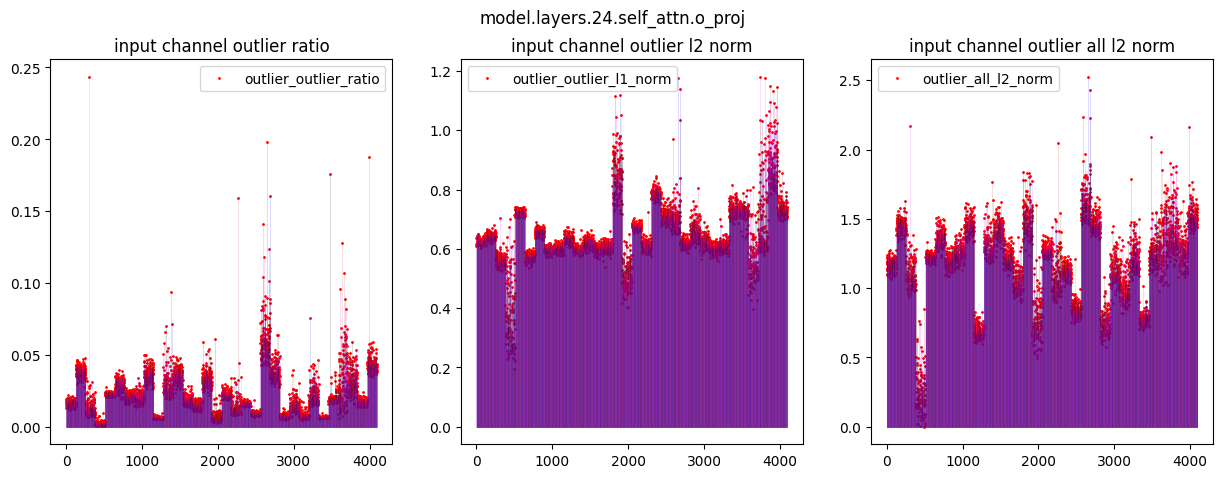

In [12]:
outlier_stats = torch.load('outlier_stats/3_sigma/llama-7b-meta_outlier.pt')

for module_name, layer_stats in outlier_stats.items():
    if 'o_proj' not in module_name:
        continue

    if int(module_name.split('.')[2]) % 8 != 0:
        continue

    plot_outlier_all_stats(layer_stats, module_name=module_name)

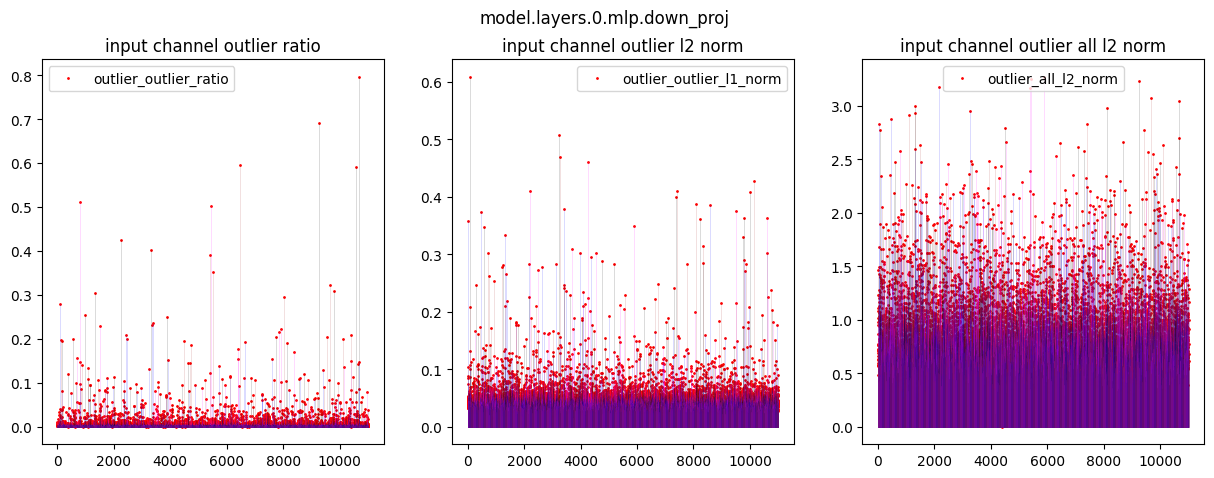

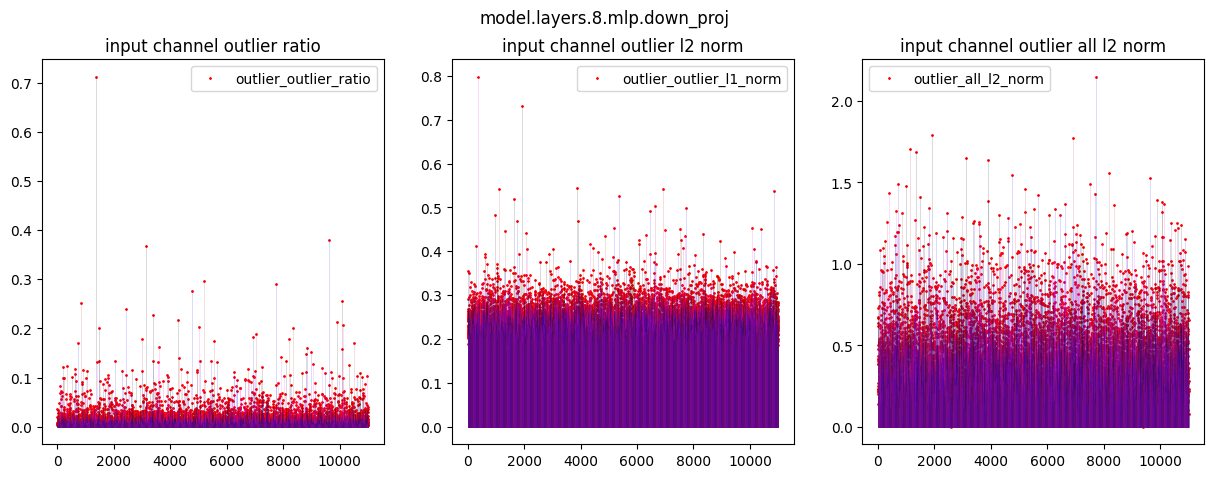

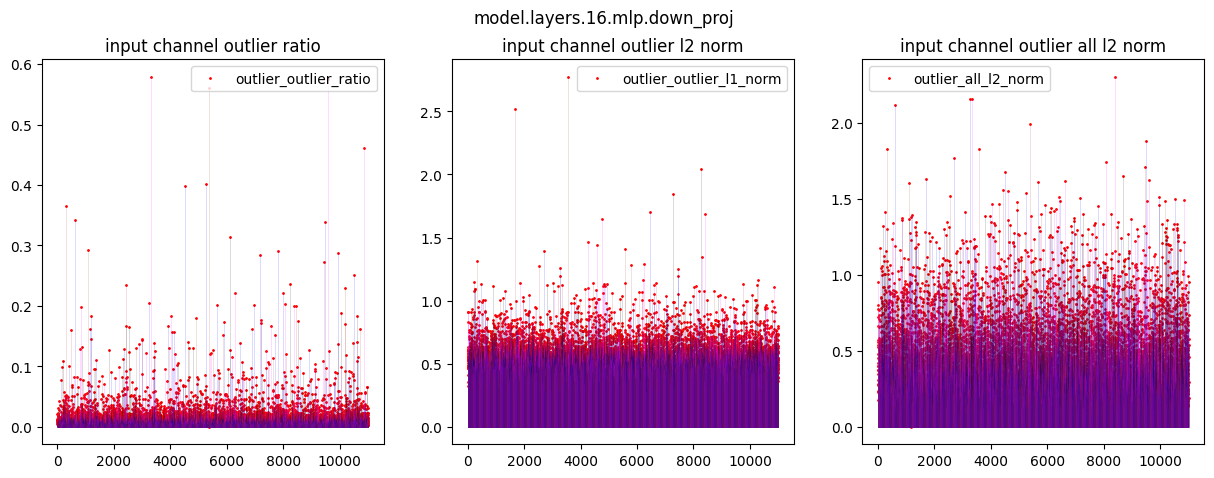

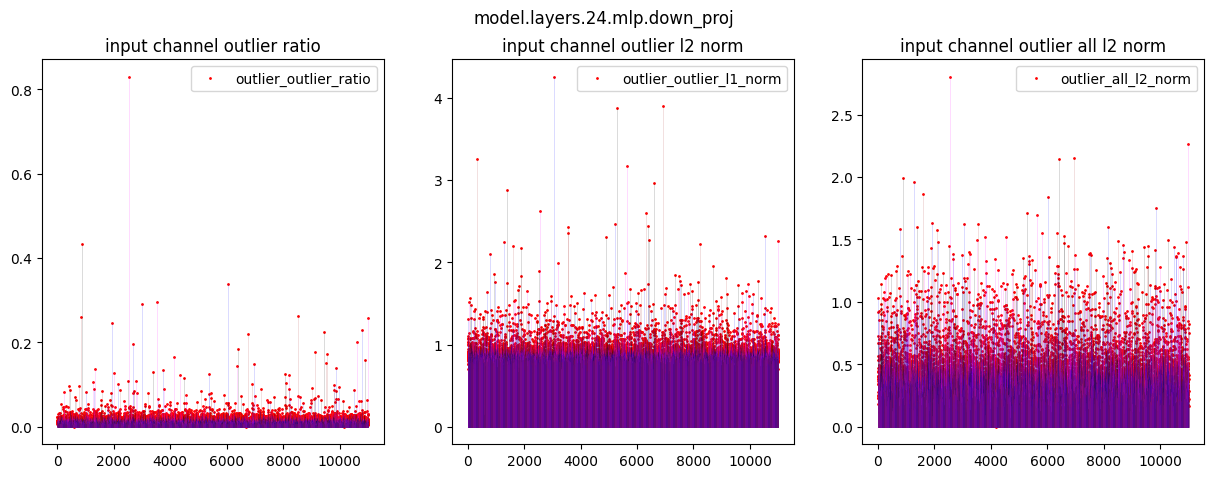

In [13]:
outlier_stats = torch.load('outlier_stats/3_sigma/llama-7b-meta_outlier.pt')

for module_name, layer_stats in outlier_stats.items():
    if 'down_proj' not in module_name:
        continue

    if int(module_name.split('.')[2]) % 8 != 0:
        continue

    plot_outlier_all_stats(layer_stats, module_name=module_name)